<a href="https://colab.research.google.com/github/SergChupin/PyTorch/blob/main/HW_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import numpy as np
import pandas as pd

from string import punctuation

from pymorphy2 import MorphAnalyzer
import re

from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
max_words = 2000
max_len = 30
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [188]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [189]:
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [190]:
df_train, df_val = train_test_split(train, test_size=0.3, random_state=42)

In [191]:
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [192]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [193]:
df_val.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [194]:
df_val['label'].value_counts()

0    8905
1     684
Name: label, dtype: int64

In [195]:
sw = set(stopwords.words('english'))
# sw

In [196]:
puncts = set(punctuation)
# puncts

In [197]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [198]:
df_train['tweet'].iloc[:1].values

array(['summer timeð\x9f\x8c\x85 #summeriscoming #swimming #picoftheday #tattoos #issho #pulsera #fluyendo  â\x80¦ '],
      dtype=object)

In [199]:
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:02<00:00, 4542.69it/s]


In [200]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [201]:
tokens = word_tokenize(train_corpus)
tokens[:5]

['summer', 'timeð\x9f\x8c', 'summeriscoming', 'swimming', 'picoftheday']

In [202]:
tokens_filtered = [word for word in tokens if word.isalnum()]
# tokens_filtered

In [203]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [204]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'u', 'im', 'life', 'time', 'like']

In [205]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [206]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [207]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 3.41 s, sys: 12.9 ms, total: 3.43 s
Wall time: 3.43 s


In [208]:
x_train.shape

(22373, 30)

In [209]:
df_train['tweet'].iloc[1]

'dese niggas show dese otha bitches fb snap nd twitter attention dey girl true ð\x9f\x92¯'

In [210]:
x_train[1]

array([1226,  107, 1389, 1625,  245, 1390,   79,  172,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [211]:
class Net(nn.Module):
    def __init__(self, vocab_size=3000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [212]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [213]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [214]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(0)


In [215]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [216]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [217]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [218]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10]. Step [44/44]. Loss: 0.150. Acc: 0.913. Test loss: 0.023. Test acc: 0.935
Epoch [2/10]. Step [44/44]. Loss: 0.117. Acc: 0.951. Test loss: 1.010. Test acc: 0.947
Epoch [3/10]. Step [44/44]. Loss: 0.151. Acc: 0.966. Test loss: 0.036. Test acc: 0.946
Epoch [4/10]. Step [44/44]. Loss: 0.079. Acc: 0.978. Test loss: 0.000. Test acc: 0.939
Epoch [5/10]. Step [44/44]. Loss: 0.067. Acc: 0.984. Test loss: 0.012. Test acc: 0.935
Epoch [6/10]. Step [44/44]. Loss: 0.041. Acc: 0.988. Test loss: 0.000. Test acc: 0.942
Epoch [7/10]. Step [44/44]. Loss: 0.033. Acc: 0.988. Test loss: 0.000. Test acc: 0.942
Epoch [8/10]. Step [44/44]. Loss: 0.011. Acc: 0.991. Test loss: 0.008. Test acc: 0.943
Epoch [9/10]. Step [44/44]. Loss: 0.026. Acc: 0.994. Test loss: 0.000. Test acc: 0.945
Epoch [10/10]. Step [44/44]. Loss: 0.035. Acc: 0.995. Test loss: 0.003. Test acc: 0.945
Training is finished!


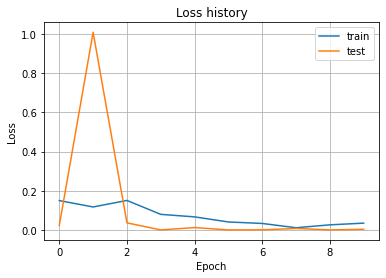

In [219]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

За счёт изменения параметров удалось добиться стабильно хорошего результата с минимальным значением функции потерь при следующих данных:

- max_words = 2000
- max_len = 30
- epochs = 10

При этом значения кол-ва эпох оказывали наибольшее влияние. В частности, при количестве эпох более 10 наблюдались скачки функции потерь. 

Получается, при слишком больших значениях мы тратим ресурсы ради получения сомнительного результата или даже получаем переобучение. А при слишком малых - недообучение. К счастью, данная модель работает шустро, и подобрать оптимальные параметры не занимает много времени.